# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

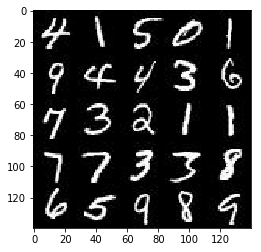

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

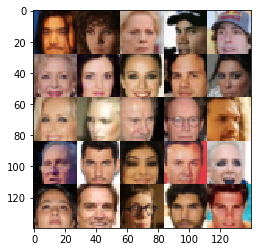

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/renan/miniconda3/envs/tf_source/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/renan/miniconda3/envs/tf_source/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/renan/miniconda3/envs/tf_source/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/renan/miniconda3/envs/tf_source/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/renan/miniconda3/envs/tf_source/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start(

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [21]:
def discriminator(images, reuse=False, n_units=128, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
         # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [31]:
def generator(z, out_channel_dim, is_train=True, n_units=128, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """    
    
    with tf.variable_scope('generator', reuse=not is_train):
               # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        # 28x28xoutput_dim now
        
        out = tf.tanh(logits)
        
        return out
        
        
        
        # First fully connected layer
#         x1 = tf.layers.dense(z, 7*7*128)
#         # Reshape it to start the convolutional stack
#         x1 = tf.reshape(x1, (-1, 7, 7, 128))
#         x1 = tf.layers.batch_normalization(x1, training=is_train)
#         x1 = tf.maximum(alpha * x1, x1)
#         # 7x7x512 now
        
#         x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=2, padding='same')
#         x2 = tf.layers.batch_normalization(x2, training=is_train)
#         x2 = tf.maximum(alpha * x2, x2)
#         # 14x14x256 now
        
        
#         # Output layer
#         logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
#         # 28x28x3 now
        
#         out = tf.tanh(logits)
        
#         return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [32]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [33]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
       # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [34]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [35]:
def train(epoch_count, batch_size, z_dim, learning_rate_scalar, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate_scalar: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    show_every = 100
    print_every=5
    n_images=25
    samples, losses = [], []
    steps = 0
    
    inputs_real, inputs_z, learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, learning_rate: learning_rate_scalar})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images, learning_rate: learning_rate_scalar})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Step {}/{} Epoch {}/{}...".format(steps, batch_size*epoch_count, epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, inputs_z, data_shape[3], data_image_mode)
                
    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step 5/128 Epoch 1/2... Discriminator Loss: 0.7185... Generator Loss: 0.8357
Step 10/128 Epoch 1/2... Discriminator Loss: 0.3036... Generator Loss: 1.6880
Step 15/128 Epoch 1/2... Discriminator Loss: 0.4044... Generator Loss: 1.5332
Step 20/128 Epoch 1/2... Discriminator Loss: 0.1431... Generator Loss: 2.4527
Step 25/128 Epoch 1/2... Discriminator Loss: 0.0835... Generator Loss: 3.1127
Step 30/128 Epoch 1/2... Discriminator Loss: 0.0375... Generator Loss: 3.7592
Step 35/128 Epoch 1/2... Discriminator Loss: 0.0419... Generator Loss: 3.6116
Step 40/128 Epoch 1/2... Discriminator Loss: 0.0341... Generator Loss: 3.8367
Step 45/128 Epoch 1/2... Discriminator Loss: 0.0233... Generator Loss: 4.1707
Step 50/128 Epoch 1/2... Discriminator Loss: 0.0191... Generator Loss: 4.2954
Step 55/128 Epoch 1/2... Discriminator Loss: 0.0129... Generator Loss: 4.8119
Step 60/128 Epoch 1/2... Discriminator Loss: 0.0283... Generator Loss: 3.9953
Step 65/128 Epoch 1/2... Discriminator Loss: 0.0488... Generator 

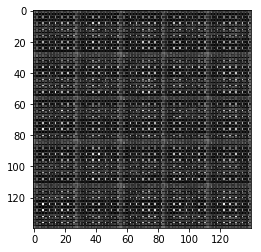

Step 105/128 Epoch 1/2... Discriminator Loss: 0.0118... Generator Loss: 5.0532
Step 110/128 Epoch 1/2... Discriminator Loss: 0.0106... Generator Loss: 5.0702
Step 115/128 Epoch 1/2... Discriminator Loss: 0.0085... Generator Loss: 5.2838
Step 120/128 Epoch 1/2... Discriminator Loss: 0.0110... Generator Loss: 4.8437
Step 125/128 Epoch 1/2... Discriminator Loss: 0.0120... Generator Loss: 4.8579
Step 130/128 Epoch 1/2... Discriminator Loss: 0.0108... Generator Loss: 4.9237
Step 135/128 Epoch 1/2... Discriminator Loss: 0.0102... Generator Loss: 5.2493
Step 140/128 Epoch 1/2... Discriminator Loss: 0.0076... Generator Loss: 5.2804
Step 145/128 Epoch 1/2... Discriminator Loss: 0.0062... Generator Loss: 5.4951
Step 150/128 Epoch 1/2... Discriminator Loss: 0.0067... Generator Loss: 5.6601
Step 155/128 Epoch 1/2... Discriminator Loss: 0.0036... Generator Loss: 6.1000
Step 160/128 Epoch 1/2... Discriminator Loss: 0.0036... Generator Loss: 5.9716
Step 165/128 Epoch 1/2... Discriminator Loss: 0.0049

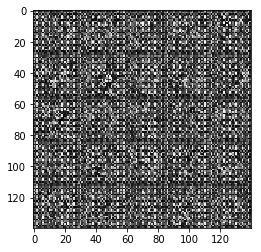

Step 205/128 Epoch 1/2... Discriminator Loss: 0.0021... Generator Loss: 6.3588
Step 210/128 Epoch 1/2... Discriminator Loss: 0.0022... Generator Loss: 6.3614
Step 215/128 Epoch 1/2... Discriminator Loss: 0.0024... Generator Loss: 6.4029
Step 220/128 Epoch 1/2... Discriminator Loss: 0.0027... Generator Loss: 6.3364
Step 225/128 Epoch 1/2... Discriminator Loss: 0.0021... Generator Loss: 6.4001
Step 230/128 Epoch 1/2... Discriminator Loss: 0.0021... Generator Loss: 6.4533
Step 235/128 Epoch 1/2... Discriminator Loss: 0.0018... Generator Loss: 6.5965
Step 240/128 Epoch 1/2... Discriminator Loss: 0.0017... Generator Loss: 6.5664
Step 245/128 Epoch 1/2... Discriminator Loss: 0.0017... Generator Loss: 6.6943
Step 250/128 Epoch 1/2... Discriminator Loss: 0.0016... Generator Loss: 6.7156
Step 255/128 Epoch 1/2... Discriminator Loss: 0.0015... Generator Loss: 6.8846
Step 260/128 Epoch 1/2... Discriminator Loss: 0.0016... Generator Loss: 6.8740
Step 265/128 Epoch 1/2... Discriminator Loss: 0.0015

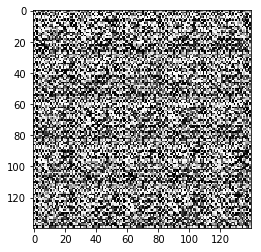

Step 305/128 Epoch 1/2... Discriminator Loss: 0.0006... Generator Loss: 7.7049
Step 310/128 Epoch 1/2... Discriminator Loss: 0.0008... Generator Loss: 7.3297
Step 315/128 Epoch 1/2... Discriminator Loss: 0.0009... Generator Loss: 7.2443
Step 320/128 Epoch 1/2... Discriminator Loss: 0.0010... Generator Loss: 7.3480
Step 325/128 Epoch 1/2... Discriminator Loss: 0.0007... Generator Loss: 7.6907
Step 330/128 Epoch 1/2... Discriminator Loss: 0.0007... Generator Loss: 7.4207
Step 335/128 Epoch 1/2... Discriminator Loss: 0.0012... Generator Loss: 7.5252
Step 340/128 Epoch 1/2... Discriminator Loss: 0.0007... Generator Loss: 7.6272
Step 345/128 Epoch 1/2... Discriminator Loss: 0.0007... Generator Loss: 7.5977
Step 350/128 Epoch 1/2... Discriminator Loss: 0.0005... Generator Loss: 7.9381
Step 355/128 Epoch 1/2... Discriminator Loss: 0.0007... Generator Loss: 7.6491
Step 360/128 Epoch 1/2... Discriminator Loss: 0.0003... Generator Loss: 8.2840
Step 365/128 Epoch 1/2... Discriminator Loss: 0.0007

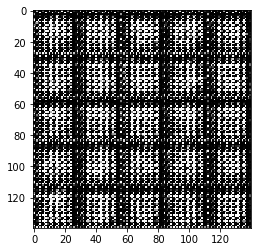

Step 405/128 Epoch 1/2... Discriminator Loss: 0.0102... Generator Loss: 5.5499
Step 410/128 Epoch 1/2... Discriminator Loss: 0.0101... Generator Loss: 5.1626
Step 415/128 Epoch 1/2... Discriminator Loss: 6.8164... Generator Loss: 12.8419
Step 420/128 Epoch 1/2... Discriminator Loss: 1.7192... Generator Loss: 0.3276
Step 425/128 Epoch 1/2... Discriminator Loss: 0.5052... Generator Loss: 9.4068
Step 430/128 Epoch 1/2... Discriminator Loss: 0.5740... Generator Loss: 11.8653
Step 435/128 Epoch 1/2... Discriminator Loss: 2.4023... Generator Loss: 0.1712
Step 440/128 Epoch 1/2... Discriminator Loss: 0.7958... Generator Loss: 3.5239
Step 445/128 Epoch 1/2... Discriminator Loss: 0.3580... Generator Loss: 1.6198
Step 450/128 Epoch 1/2... Discriminator Loss: 0.1741... Generator Loss: 2.3353
Step 455/128 Epoch 1/2... Discriminator Loss: 0.4055... Generator Loss: 1.4454
Step 460/128 Epoch 1/2... Discriminator Loss: 2.1517... Generator Loss: 1.5871
Step 465/128 Epoch 1/2... Discriminator Loss: 0.82

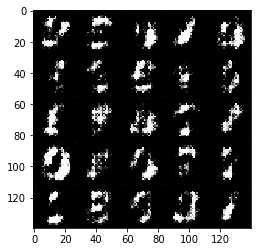

Step 505/128 Epoch 1/2... Discriminator Loss: 0.4673... Generator Loss: 1.9563
Step 510/128 Epoch 1/2... Discriminator Loss: 0.5643... Generator Loss: 1.2955
Step 515/128 Epoch 1/2... Discriminator Loss: 0.4861... Generator Loss: 1.5621
Step 520/128 Epoch 1/2... Discriminator Loss: 0.4934... Generator Loss: 1.8475
Step 525/128 Epoch 1/2... Discriminator Loss: 0.4373... Generator Loss: 1.8865
Step 530/128 Epoch 1/2... Discriminator Loss: 0.3135... Generator Loss: 2.0186
Step 535/128 Epoch 1/2... Discriminator Loss: 0.3245... Generator Loss: 2.0168
Step 540/128 Epoch 1/2... Discriminator Loss: 0.3643... Generator Loss: 1.6093
Step 545/128 Epoch 1/2... Discriminator Loss: 0.2558... Generator Loss: 1.8601
Step 550/128 Epoch 1/2... Discriminator Loss: 0.2419... Generator Loss: 2.3380
Step 555/128 Epoch 1/2... Discriminator Loss: 0.1968... Generator Loss: 2.2020
Step 560/128 Epoch 1/2... Discriminator Loss: 0.1815... Generator Loss: 2.3474
Step 565/128 Epoch 1/2... Discriminator Loss: 0.1483

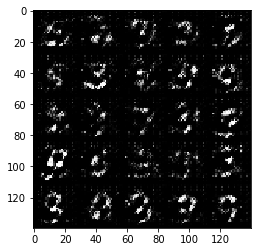

Step 605/128 Epoch 1/2... Discriminator Loss: 0.1106... Generator Loss: 3.1796
Step 610/128 Epoch 1/2... Discriminator Loss: 0.1078... Generator Loss: 3.0204
Step 615/128 Epoch 1/2... Discriminator Loss: 0.0317... Generator Loss: 4.2836
Step 620/128 Epoch 1/2... Discriminator Loss: 0.0698... Generator Loss: 3.4127
Step 625/128 Epoch 1/2... Discriminator Loss: 0.0804... Generator Loss: 3.7189
Step 630/128 Epoch 1/2... Discriminator Loss: 0.0576... Generator Loss: 3.3328
Step 635/128 Epoch 1/2... Discriminator Loss: 0.0658... Generator Loss: 3.2160
Step 640/128 Epoch 1/2... Discriminator Loss: 0.1098... Generator Loss: 2.8944
Step 645/128 Epoch 1/2... Discriminator Loss: 0.0448... Generator Loss: 3.5156
Step 650/128 Epoch 1/2... Discriminator Loss: 0.1008... Generator Loss: 3.7268
Step 655/128 Epoch 1/2... Discriminator Loss: 0.0445... Generator Loss: 3.5982
Step 660/128 Epoch 1/2... Discriminator Loss: 0.0161... Generator Loss: 4.6042
Step 665/128 Epoch 1/2... Discriminator Loss: 0.0558

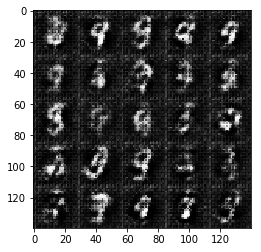

Step 705/128 Epoch 1/2... Discriminator Loss: 1.4901... Generator Loss: 8.1133
Step 710/128 Epoch 1/2... Discriminator Loss: 0.5064... Generator Loss: 1.1743
Step 715/128 Epoch 1/2... Discriminator Loss: 0.2116... Generator Loss: 2.0421
Step 720/128 Epoch 1/2... Discriminator Loss: 0.1118... Generator Loss: 3.8077
Step 725/128 Epoch 1/2... Discriminator Loss: 0.0907... Generator Loss: 3.4096
Step 730/128 Epoch 1/2... Discriminator Loss: 0.4988... Generator Loss: 6.6525
Step 735/128 Epoch 1/2... Discriminator Loss: 0.1138... Generator Loss: 2.8931
Step 740/128 Epoch 1/2... Discriminator Loss: 0.2384... Generator Loss: 2.7807
Step 745/128 Epoch 1/2... Discriminator Loss: 1.8859... Generator Loss: 8.9567
Step 750/128 Epoch 1/2... Discriminator Loss: 0.3534... Generator Loss: 1.8965
Step 755/128 Epoch 1/2... Discriminator Loss: 0.1127... Generator Loss: 5.0291
Step 760/128 Epoch 1/2... Discriminator Loss: 0.4017... Generator Loss: 8.1077
Step 765/128 Epoch 1/2... Discriminator Loss: 0.0744

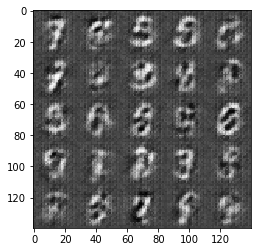

Step 805/128 Epoch 1/2... Discriminator Loss: 0.1245... Generator Loss: 4.3041
Step 810/128 Epoch 1/2... Discriminator Loss: 0.1884... Generator Loss: 2.6688
Step 815/128 Epoch 1/2... Discriminator Loss: 0.0643... Generator Loss: 4.8873
Step 820/128 Epoch 1/2... Discriminator Loss: 0.4957... Generator Loss: 1.9585
Step 825/128 Epoch 1/2... Discriminator Loss: 0.3431... Generator Loss: 2.0313
Step 830/128 Epoch 1/2... Discriminator Loss: 1.0824... Generator Loss: 0.5593
Step 835/128 Epoch 1/2... Discriminator Loss: 0.1164... Generator Loss: 5.1249
Step 840/128 Epoch 1/2... Discriminator Loss: 0.3943... Generator Loss: 2.4062
Step 845/128 Epoch 1/2... Discriminator Loss: 0.4790... Generator Loss: 4.7546
Step 850/128 Epoch 1/2... Discriminator Loss: 0.2474... Generator Loss: 2.0572
Step 855/128 Epoch 1/2... Discriminator Loss: 0.7483... Generator Loss: 4.6529
Step 860/128 Epoch 1/2... Discriminator Loss: 0.3684... Generator Loss: 1.4754
Step 865/128 Epoch 1/2... Discriminator Loss: 0.5036

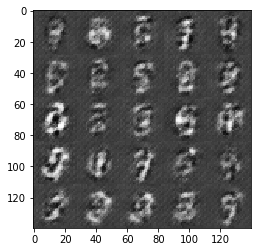

Step 905/128 Epoch 1/2... Discriminator Loss: 0.8669... Generator Loss: 5.0919
Step 910/128 Epoch 1/2... Discriminator Loss: 0.2573... Generator Loss: 4.0148
Step 915/128 Epoch 1/2... Discriminator Loss: 0.3751... Generator Loss: 1.5811
Step 920/128 Epoch 1/2... Discriminator Loss: 0.1434... Generator Loss: 3.2422
Step 925/128 Epoch 1/2... Discriminator Loss: 0.3124... Generator Loss: 1.6890
Step 930/128 Epoch 1/2... Discriminator Loss: 0.1241... Generator Loss: 3.2857
Step 935/128 Epoch 1/2... Discriminator Loss: 0.3293... Generator Loss: 4.7265
Step 940/128 Epoch 2/2... Discriminator Loss: 0.7042... Generator Loss: 0.8539
Step 945/128 Epoch 2/2... Discriminator Loss: 0.1507... Generator Loss: 4.0724
Step 950/128 Epoch 2/2... Discriminator Loss: 0.1453... Generator Loss: 2.7200
Step 955/128 Epoch 2/2... Discriminator Loss: 0.1370... Generator Loss: 2.8351
Step 960/128 Epoch 2/2... Discriminator Loss: 0.2018... Generator Loss: 3.2060
Step 965/128 Epoch 2/2... Discriminator Loss: 0.5642

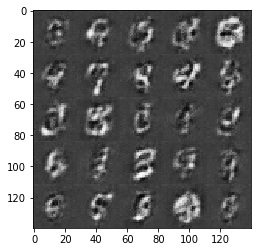

Step 1005/128 Epoch 2/2... Discriminator Loss: 0.1586... Generator Loss: 2.9690
Step 1010/128 Epoch 2/2... Discriminator Loss: 0.2751... Generator Loss: 1.8158
Step 1015/128 Epoch 2/2... Discriminator Loss: 0.2401... Generator Loss: 3.0652
Step 1020/128 Epoch 2/2... Discriminator Loss: 0.3287... Generator Loss: 1.5988
Step 1025/128 Epoch 2/2... Discriminator Loss: 0.1233... Generator Loss: 3.2885
Step 1030/128 Epoch 2/2... Discriminator Loss: 0.3269... Generator Loss: 1.7771
Step 1035/128 Epoch 2/2... Discriminator Loss: 0.2813... Generator Loss: 1.8854
Step 1040/128 Epoch 2/2... Discriminator Loss: 0.1912... Generator Loss: 2.4290
Step 1045/128 Epoch 2/2... Discriminator Loss: 0.1811... Generator Loss: 3.7093
Step 1050/128 Epoch 2/2... Discriminator Loss: 0.4764... Generator Loss: 1.3886
Step 1055/128 Epoch 2/2... Discriminator Loss: 0.2772... Generator Loss: 2.5587
Step 1060/128 Epoch 2/2... Discriminator Loss: 0.2143... Generator Loss: 2.4016
Step 1065/128 Epoch 2/2... Discriminator

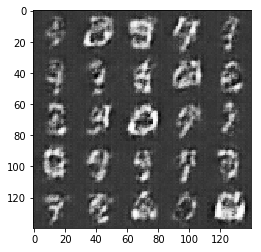

Step 1105/128 Epoch 2/2... Discriminator Loss: 0.1319... Generator Loss: 3.3043
Step 1110/128 Epoch 2/2... Discriminator Loss: 0.2537... Generator Loss: 2.0024
Step 1115/128 Epoch 2/2... Discriminator Loss: 0.1968... Generator Loss: 2.6369
Step 1120/128 Epoch 2/2... Discriminator Loss: 0.2178... Generator Loss: 2.1552
Step 1125/128 Epoch 2/2... Discriminator Loss: 0.1937... Generator Loss: 3.2669
Step 1130/128 Epoch 2/2... Discriminator Loss: 0.2039... Generator Loss: 2.3618
Step 1135/128 Epoch 2/2... Discriminator Loss: 0.1711... Generator Loss: 3.6108
Step 1140/128 Epoch 2/2... Discriminator Loss: 0.2003... Generator Loss: 3.3192
Step 1145/128 Epoch 2/2... Discriminator Loss: 0.8683... Generator Loss: 5.1066
Step 1150/128 Epoch 2/2... Discriminator Loss: 0.3193... Generator Loss: 1.6326
Step 1155/128 Epoch 2/2... Discriminator Loss: 0.1829... Generator Loss: 3.0526
Step 1160/128 Epoch 2/2... Discriminator Loss: 0.1877... Generator Loss: 2.9438
Step 1165/128 Epoch 2/2... Discriminator

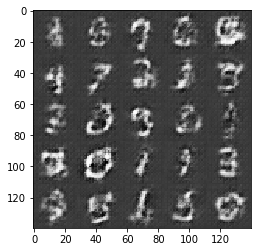

Step 1205/128 Epoch 2/2... Discriminator Loss: 2.0783... Generator Loss: 0.1903
Step 1210/128 Epoch 2/2... Discriminator Loss: 0.3203... Generator Loss: 2.2664
Step 1215/128 Epoch 2/2... Discriminator Loss: 0.2216... Generator Loss: 2.5861
Step 1220/128 Epoch 2/2... Discriminator Loss: 0.2292... Generator Loss: 2.2200
Step 1225/128 Epoch 2/2... Discriminator Loss: 0.2879... Generator Loss: 1.8555
Step 1230/128 Epoch 2/2... Discriminator Loss: 0.1930... Generator Loss: 2.4777
Step 1235/128 Epoch 2/2... Discriminator Loss: 0.1430... Generator Loss: 2.8298
Step 1240/128 Epoch 2/2... Discriminator Loss: 0.1147... Generator Loss: 3.6110
Step 1245/128 Epoch 2/2... Discriminator Loss: 0.2439... Generator Loss: 1.9530
Step 1250/128 Epoch 2/2... Discriminator Loss: 0.1720... Generator Loss: 5.3286
Step 1255/128 Epoch 2/2... Discriminator Loss: 0.1668... Generator Loss: 2.3712
Step 1260/128 Epoch 2/2... Discriminator Loss: 0.1877... Generator Loss: 3.3198
Step 1265/128 Epoch 2/2... Discriminator

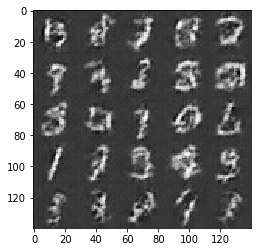

Step 1305/128 Epoch 2/2... Discriminator Loss: 0.1815... Generator Loss: 2.6015
Step 1310/128 Epoch 2/2... Discriminator Loss: 0.1931... Generator Loss: 2.5896
Step 1315/128 Epoch 2/2... Discriminator Loss: 0.1553... Generator Loss: 2.7768
Step 1320/128 Epoch 2/2... Discriminator Loss: 0.1542... Generator Loss: 3.0365
Step 1325/128 Epoch 2/2... Discriminator Loss: 0.2069... Generator Loss: 2.1001
Step 1330/128 Epoch 2/2... Discriminator Loss: 0.2986... Generator Loss: 4.2233
Step 1335/128 Epoch 2/2... Discriminator Loss: 0.5295... Generator Loss: 1.1666
Step 1340/128 Epoch 2/2... Discriminator Loss: 0.1915... Generator Loss: 2.2353
Step 1345/128 Epoch 2/2... Discriminator Loss: 0.1250... Generator Loss: 2.8772
Step 1350/128 Epoch 2/2... Discriminator Loss: 0.1408... Generator Loss: 3.3006
Step 1355/128 Epoch 2/2... Discriminator Loss: 0.0915... Generator Loss: 3.0121
Step 1360/128 Epoch 2/2... Discriminator Loss: 1.2558... Generator Loss: 5.7791
Step 1365/128 Epoch 2/2... Discriminator

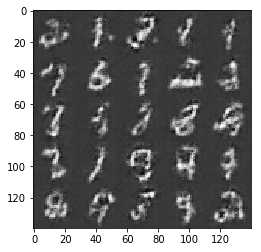

Step 1405/128 Epoch 2/2... Discriminator Loss: 0.3519... Generator Loss: 1.7804
Step 1410/128 Epoch 2/2... Discriminator Loss: 0.2050... Generator Loss: 2.4662
Step 1415/128 Epoch 2/2... Discriminator Loss: 0.1639... Generator Loss: 2.5794
Step 1420/128 Epoch 2/2... Discriminator Loss: 0.1596... Generator Loss: 2.4266
Step 1425/128 Epoch 2/2... Discriminator Loss: 0.2704... Generator Loss: 1.6924
Step 1430/128 Epoch 2/2... Discriminator Loss: 0.1332... Generator Loss: 3.8688
Step 1435/128 Epoch 2/2... Discriminator Loss: 0.1452... Generator Loss: 2.7072
Step 1440/128 Epoch 2/2... Discriminator Loss: 0.0995... Generator Loss: 3.9022
Step 1445/128 Epoch 2/2... Discriminator Loss: 0.1361... Generator Loss: 2.5589
Step 1450/128 Epoch 2/2... Discriminator Loss: 0.0768... Generator Loss: 3.7732
Step 1455/128 Epoch 2/2... Discriminator Loss: 0.1523... Generator Loss: 2.4329
Step 1460/128 Epoch 2/2... Discriminator Loss: 0.0774... Generator Loss: 3.6155
Step 1465/128 Epoch 2/2... Discriminator

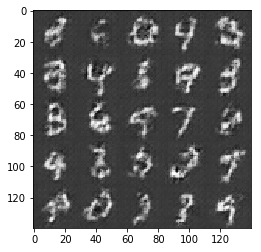

Step 1505/128 Epoch 2/2... Discriminator Loss: 0.1760... Generator Loss: 2.2440
Step 1510/128 Epoch 2/2... Discriminator Loss: 0.0918... Generator Loss: 3.0307
Step 1515/128 Epoch 2/2... Discriminator Loss: 0.2751... Generator Loss: 1.7953
Step 1520/128 Epoch 2/2... Discriminator Loss: 0.1845... Generator Loss: 4.5789
Step 1525/128 Epoch 2/2... Discriminator Loss: 0.1299... Generator Loss: 2.4804
Step 1530/128 Epoch 2/2... Discriminator Loss: 0.1223... Generator Loss: 2.5660
Step 1535/128 Epoch 2/2... Discriminator Loss: 0.0916... Generator Loss: 2.8985
Step 1540/128 Epoch 2/2... Discriminator Loss: 0.0503... Generator Loss: 3.7453
Step 1545/128 Epoch 2/2... Discriminator Loss: 0.2915... Generator Loss: 1.7295
Step 1550/128 Epoch 2/2... Discriminator Loss: 0.1195... Generator Loss: 5.7404
Step 1555/128 Epoch 2/2... Discriminator Loss: 0.1140... Generator Loss: 2.7240
Step 1560/128 Epoch 2/2... Discriminator Loss: 0.0987... Generator Loss: 2.9001
Step 1565/128 Epoch 2/2... Discriminator

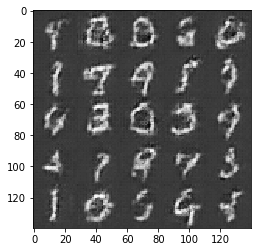

Step 1605/128 Epoch 2/2... Discriminator Loss: 0.1325... Generator Loss: 2.8667
Step 1610/128 Epoch 2/2... Discriminator Loss: 0.1809... Generator Loss: 2.3283
Step 1615/128 Epoch 2/2... Discriminator Loss: 0.1881... Generator Loss: 2.2450
Step 1620/128 Epoch 2/2... Discriminator Loss: 0.0929... Generator Loss: 3.0536
Step 1625/128 Epoch 2/2... Discriminator Loss: 0.1020... Generator Loss: 3.9901
Step 1630/128 Epoch 2/2... Discriminator Loss: 0.0915... Generator Loss: 3.3711
Step 1635/128 Epoch 2/2... Discriminator Loss: 0.1312... Generator Loss: 3.0043
Step 1640/128 Epoch 2/2... Discriminator Loss: 0.0514... Generator Loss: 4.1512
Step 1645/128 Epoch 2/2... Discriminator Loss: 0.2696... Generator Loss: 1.7952
Step 1650/128 Epoch 2/2... Discriminator Loss: 0.0764... Generator Loss: 4.6136
Step 1655/128 Epoch 2/2... Discriminator Loss: 0.2128... Generator Loss: 3.2820
Step 1660/128 Epoch 2/2... Discriminator Loss: 0.1609... Generator Loss: 4.5091
Step 1665/128 Epoch 2/2... Discriminator

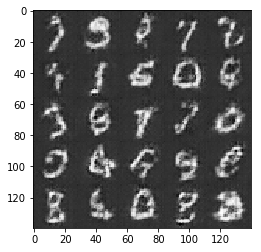

Step 1705/128 Epoch 2/2... Discriminator Loss: 0.0927... Generator Loss: 2.9832
Step 1710/128 Epoch 2/2... Discriminator Loss: 0.0467... Generator Loss: 4.1244
Step 1715/128 Epoch 2/2... Discriminator Loss: 0.2345... Generator Loss: 1.9355
Step 1720/128 Epoch 2/2... Discriminator Loss: 0.0466... Generator Loss: 4.4729
Step 1725/128 Epoch 2/2... Discriminator Loss: 0.1688... Generator Loss: 2.3127
Step 1730/128 Epoch 2/2... Discriminator Loss: 0.0611... Generator Loss: 3.5238
Step 1735/128 Epoch 2/2... Discriminator Loss: 0.2584... Generator Loss: 2.0249
Step 1740/128 Epoch 2/2... Discriminator Loss: 0.3622... Generator Loss: 3.7147
Step 1745/128 Epoch 2/2... Discriminator Loss: 0.0718... Generator Loss: 3.3155
Step 1750/128 Epoch 2/2... Discriminator Loss: 0.4637... Generator Loss: 1.2928
Step 1755/128 Epoch 2/2... Discriminator Loss: 0.1354... Generator Loss: 5.6737
Step 1760/128 Epoch 2/2... Discriminator Loss: 0.2936... Generator Loss: 1.8041
Step 1765/128 Epoch 2/2... Discriminator

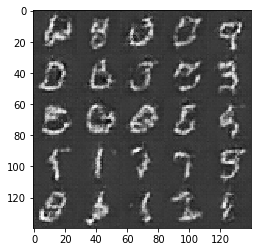

Step 1805/128 Epoch 2/2... Discriminator Loss: 0.2252... Generator Loss: 2.0607
Step 1810/128 Epoch 2/2... Discriminator Loss: 0.1381... Generator Loss: 2.6799
Step 1815/128 Epoch 2/2... Discriminator Loss: 0.0948... Generator Loss: 3.4246
Step 1820/128 Epoch 2/2... Discriminator Loss: 0.0798... Generator Loss: 3.4059
Step 1825/128 Epoch 2/2... Discriminator Loss: 0.1769... Generator Loss: 2.3645
Step 1830/128 Epoch 2/2... Discriminator Loss: 0.0692... Generator Loss: 4.1105
Step 1835/128 Epoch 2/2... Discriminator Loss: 0.0817... Generator Loss: 4.0393
Step 1840/128 Epoch 2/2... Discriminator Loss: 0.4742... Generator Loss: 1.2167
Step 1845/128 Epoch 2/2... Discriminator Loss: 0.0410... Generator Loss: 4.4109
Step 1850/128 Epoch 2/2... Discriminator Loss: 0.0568... Generator Loss: 3.6282
Step 1855/128 Epoch 2/2... Discriminator Loss: 0.0613... Generator Loss: 3.4939
Step 1860/128 Epoch 2/2... Discriminator Loss: 0.1086... Generator Loss: 3.1702
Step 1865/128 Epoch 2/2... Discriminator

In [37]:
batch_size = 64
z_dim = 100
learning_rate_scalar = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate_scalar, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

In [ ]:
#antigo zoado
batch_size = 64
z_dim = 100
learning_rate_scalar = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate_scalar, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step 5/64 Epoch 1/1... Discriminator Loss: 1.9885... Generator Loss: 0.2822
Step 10/64 Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 0.7187
Step 15/64 Epoch 1/1... Discriminator Loss: 0.6815... Generator Loss: 1.0775
Step 20/64 Epoch 1/1... Discriminator Loss: 0.5383... Generator Loss: 1.2322
Step 25/64 Epoch 1/1... Discriminator Loss: 0.5946... Generator Loss: 1.3376
Step 30/64 Epoch 1/1... Discriminator Loss: 0.5901... Generator Loss: 1.2293
Step 35/64 Epoch 1/1... Discriminator Loss: 0.5665... Generator Loss: 1.6138
Step 40/64 Epoch 1/1... Discriminator Loss: 0.4392... Generator Loss: 1.7185
Step 45/64 Epoch 1/1... Discriminator Loss: 0.7592... Generator Loss: 0.9379
Step 50/64 Epoch 1/1... Discriminator Loss: 0.5120... Generator Loss: 1.4375
Step 55/64 Epoch 1/1... Discriminator Loss: 0.5451... Generator Loss: 1.4889
Step 60/64 Epoch 1/1... Discriminator Loss: 0.7381... Generator Loss: 2.4544
Step 65/64 Epoch 1/1... Discriminator Loss: 0.6554... Generator Loss: 1.7460


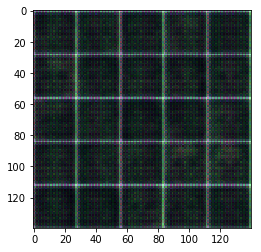

Step 105/64 Epoch 1/1... Discriminator Loss: 0.3089... Generator Loss: 2.0171
Step 110/64 Epoch 1/1... Discriminator Loss: 0.3128... Generator Loss: 1.8878
Step 115/64 Epoch 1/1... Discriminator Loss: 0.3245... Generator Loss: 1.8579
Step 120/64 Epoch 1/1... Discriminator Loss: 0.2298... Generator Loss: 3.2913
Step 125/64 Epoch 1/1... Discriminator Loss: 0.2145... Generator Loss: 2.4559
Step 130/64 Epoch 1/1... Discriminator Loss: 0.2698... Generator Loss: 1.7490
Step 135/64 Epoch 1/1... Discriminator Loss: 0.4297... Generator Loss: 1.3322
Step 140/64 Epoch 1/1... Discriminator Loss: 0.1212... Generator Loss: 4.5098
Step 145/64 Epoch 1/1... Discriminator Loss: 0.2635... Generator Loss: 1.8833
Step 150/64 Epoch 1/1... Discriminator Loss: 0.5009... Generator Loss: 4.2741
Step 155/64 Epoch 1/1... Discriminator Loss: 0.0704... Generator Loss: 3.8806
Step 160/64 Epoch 1/1... Discriminator Loss: 0.4162... Generator Loss: 1.3275
Step 165/64 Epoch 1/1... Discriminator Loss: 0.1329... Generator

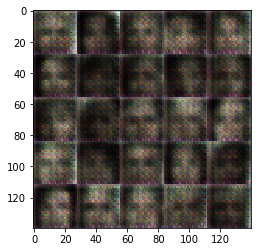

Step 205/64 Epoch 1/1... Discriminator Loss: 0.5875... Generator Loss: 1.0211
Step 210/64 Epoch 1/1... Discriminator Loss: 0.4628... Generator Loss: 1.3867
Step 215/64 Epoch 1/1... Discriminator Loss: 0.0137... Generator Loss: 7.5342
Step 220/64 Epoch 1/1... Discriminator Loss: 0.1231... Generator Loss: 2.9943
Step 225/64 Epoch 1/1... Discriminator Loss: 0.0657... Generator Loss: 3.3985
Step 230/64 Epoch 1/1... Discriminator Loss: 0.1377... Generator Loss: 2.5891
Step 235/64 Epoch 1/1... Discriminator Loss: 0.0707... Generator Loss: 3.5093
Step 240/64 Epoch 1/1... Discriminator Loss: 0.1925... Generator Loss: 8.7052
Step 245/64 Epoch 1/1... Discriminator Loss: 0.6601... Generator Loss: 0.9826
Step 250/64 Epoch 1/1... Discriminator Loss: 0.0696... Generator Loss: 6.2597
Step 255/64 Epoch 1/1... Discriminator Loss: 0.8515... Generator Loss: 0.7803
Step 260/64 Epoch 1/1... Discriminator Loss: 4.6399... Generator Loss: 0.0267
Step 265/64 Epoch 1/1... Discriminator Loss: 0.6135... Generator

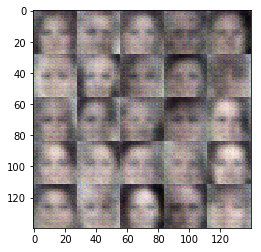

Step 305/64 Epoch 1/1... Discriminator Loss: 1.8334... Generator Loss: 0.2367
Step 310/64 Epoch 1/1... Discriminator Loss: 0.4973... Generator Loss: 1.4506
Step 315/64 Epoch 1/1... Discriminator Loss: 0.0330... Generator Loss: 7.8878
Step 320/64 Epoch 1/1... Discriminator Loss: 0.1305... Generator Loss: 3.0644
Step 325/64 Epoch 1/1... Discriminator Loss: 0.1458... Generator Loss: 3.0274
Step 330/64 Epoch 1/1... Discriminator Loss: 2.4198... Generator Loss: 0.1459
Step 335/64 Epoch 1/1... Discriminator Loss: 0.1285... Generator Loss: 7.7466
Step 340/64 Epoch 1/1... Discriminator Loss: 0.6582... Generator Loss: 14.9960
Step 345/64 Epoch 1/1... Discriminator Loss: 2.4360... Generator Loss: 0.1144
Step 350/64 Epoch 1/1... Discriminator Loss: 0.2741... Generator Loss: 2.5558
Step 355/64 Epoch 1/1... Discriminator Loss: 0.0624... Generator Loss: 6.4703
Step 360/64 Epoch 1/1... Discriminator Loss: 0.0925... Generator Loss: 6.3108
Step 365/64 Epoch 1/1... Discriminator Loss: 3.3253... Generato

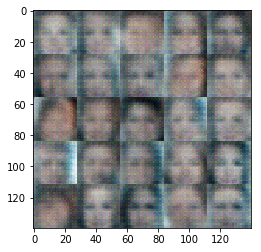

Step 405/64 Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 11.3249
Step 410/64 Epoch 1/1... Discriminator Loss: 0.4258... Generator Loss: 2.1157
Step 415/64 Epoch 1/1... Discriminator Loss: 0.5557... Generator Loss: 1.2080
Step 420/64 Epoch 1/1... Discriminator Loss: 0.5323... Generator Loss: 1.3014
Step 425/64 Epoch 1/1... Discriminator Loss: 0.2892... Generator Loss: 9.3869
Step 430/64 Epoch 1/1... Discriminator Loss: 0.3996... Generator Loss: 6.5486
Step 435/64 Epoch 1/1... Discriminator Loss: 0.1844... Generator Loss: 2.7238
Step 440/64 Epoch 1/1... Discriminator Loss: 0.0197... Generator Loss: 5.8097
Step 445/64 Epoch 1/1... Discriminator Loss: 0.9188... Generator Loss: 0.7233
Step 450/64 Epoch 1/1... Discriminator Loss: 0.4016... Generator Loss: 1.4319
Step 455/64 Epoch 1/1... Discriminator Loss: 0.2602... Generator Loss: 1.9748
Step 460/64 Epoch 1/1... Discriminator Loss: 0.3505... Generator Loss: 4.9291
Step 465/64 Epoch 1/1... Discriminator Loss: 0.1917... Generato

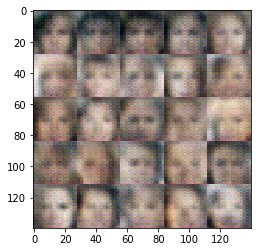

Step 505/64 Epoch 1/1... Discriminator Loss: 0.2799... Generator Loss: 1.7051
Step 510/64 Epoch 1/1... Discriminator Loss: 0.6474... Generator Loss: 7.5939
Step 515/64 Epoch 1/1... Discriminator Loss: 1.0322... Generator Loss: 0.6830
Step 520/64 Epoch 1/1... Discriminator Loss: 3.7091... Generator Loss: 0.0366
Step 525/64 Epoch 1/1... Discriminator Loss: 0.4036... Generator Loss: 4.7184
Step 530/64 Epoch 1/1... Discriminator Loss: 0.1502... Generator Loss: 7.6456
Step 535/64 Epoch 1/1... Discriminator Loss: 0.2553... Generator Loss: 2.0759
Step 540/64 Epoch 1/1... Discriminator Loss: 0.3605... Generator Loss: 1.5559
Step 545/64 Epoch 1/1... Discriminator Loss: 0.2316... Generator Loss: 2.1524
Step 550/64 Epoch 1/1... Discriminator Loss: 0.3171... Generator Loss: 7.6775
Step 555/64 Epoch 1/1... Discriminator Loss: 0.3345... Generator Loss: 3.2170
Step 560/64 Epoch 1/1... Discriminator Loss: 0.4778... Generator Loss: 1.4446
Step 565/64 Epoch 1/1... Discriminator Loss: 0.7304... Generator

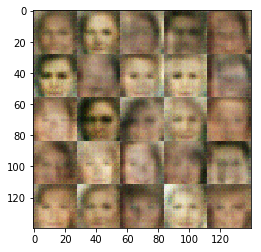

Step 605/64 Epoch 1/1... Discriminator Loss: 0.4063... Generator Loss: 1.4105
Step 610/64 Epoch 1/1... Discriminator Loss: 0.1321... Generator Loss: 6.7618
Step 615/64 Epoch 1/1... Discriminator Loss: 0.0974... Generator Loss: 6.9460
Step 620/64 Epoch 1/1... Discriminator Loss: 1.4867... Generator Loss: 0.3201
Step 625/64 Epoch 1/1... Discriminator Loss: 0.0863... Generator Loss: 3.6901
Step 630/64 Epoch 1/1... Discriminator Loss: 0.0451... Generator Loss: 6.0535
Step 635/64 Epoch 1/1... Discriminator Loss: 2.5672... Generator Loss: 0.0959
Step 640/64 Epoch 1/1... Discriminator Loss: 0.1310... Generator Loss: 4.8990
Step 645/64 Epoch 1/1... Discriminator Loss: 0.4961... Generator Loss: 1.2102
Step 650/64 Epoch 1/1... Discriminator Loss: 1.1071... Generator Loss: 3.5993
Step 655/64 Epoch 1/1... Discriminator Loss: 0.0937... Generator Loss: 11.3440
Step 660/64 Epoch 1/1... Discriminator Loss: 0.3403... Generator Loss: 3.3878
Step 665/64 Epoch 1/1... Discriminator Loss: 0.5747... Generato

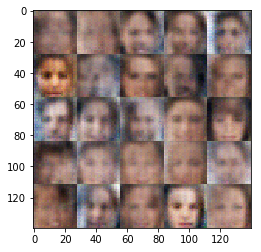

Step 705/64 Epoch 1/1... Discriminator Loss: 0.7249... Generator Loss: 3.1285
Step 710/64 Epoch 1/1... Discriminator Loss: 0.6739... Generator Loss: 4.8236
Step 715/64 Epoch 1/1... Discriminator Loss: 0.3585... Generator Loss: 11.5462
Step 720/64 Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 7.9085
Step 725/64 Epoch 1/1... Discriminator Loss: 0.4704... Generator Loss: 1.2180
Step 730/64 Epoch 1/1... Discriminator Loss: 0.6669... Generator Loss: 10.7385
Step 735/64 Epoch 1/1... Discriminator Loss: 0.1799... Generator Loss: 5.3731
Step 740/64 Epoch 1/1... Discriminator Loss: 0.1569... Generator Loss: 6.1976
Step 745/64 Epoch 1/1... Discriminator Loss: 0.6940... Generator Loss: 0.9072
Step 750/64 Epoch 1/1... Discriminator Loss: 0.2649... Generator Loss: 1.9882
Step 755/64 Epoch 1/1... Discriminator Loss: 0.1753... Generator Loss: 2.3606
Step 760/64 Epoch 1/1... Discriminator Loss: 0.0834... Generator Loss: 6.0568
Step 765/64 Epoch 1/1... Discriminator Loss: 0.4817... Generat

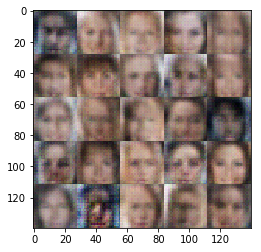

Step 805/64 Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.3346
Step 810/64 Epoch 1/1... Discriminator Loss: 0.1914... Generator Loss: 2.1631
Step 815/64 Epoch 1/1... Discriminator Loss: 0.4265... Generator Loss: 1.2256
Step 820/64 Epoch 1/1... Discriminator Loss: 0.0875... Generator Loss: 3.2254
Step 825/64 Epoch 1/1... Discriminator Loss: 0.1815... Generator Loss: 2.2611
Step 830/64 Epoch 1/1... Discriminator Loss: 0.7633... Generator Loss: 11.1500
Step 835/64 Epoch 1/1... Discriminator Loss: 0.1148... Generator Loss: 7.1923
Step 840/64 Epoch 1/1... Discriminator Loss: 1.9625... Generator Loss: 0.1972
Step 845/64 Epoch 1/1... Discriminator Loss: 0.3954... Generator Loss: 1.3699
Step 850/64 Epoch 1/1... Discriminator Loss: 0.0609... Generator Loss: 7.6577
Step 855/64 Epoch 1/1... Discriminator Loss: 0.2422... Generator Loss: 3.4904
Step 860/64 Epoch 1/1... Discriminator Loss: 0.8218... Generator Loss: 0.7793
Step 865/64 Epoch 1/1... Discriminator Loss: 0.0471... Generato

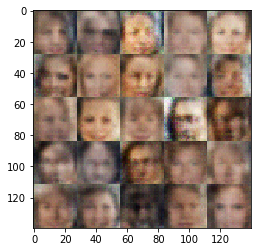

Step 905/64 Epoch 1/1... Discriminator Loss: 0.7089... Generator Loss: 13.6822
Step 910/64 Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.4319
Step 915/64 Epoch 1/1... Discriminator Loss: 0.2162... Generator Loss: 2.5791
Step 920/64 Epoch 1/1... Discriminator Loss: 0.4653... Generator Loss: 8.6193
Step 925/64 Epoch 1/1... Discriminator Loss: 0.3287... Generator Loss: 1.9926
Step 930/64 Epoch 1/1... Discriminator Loss: 0.1002... Generator Loss: 6.8987
Step 935/64 Epoch 1/1... Discriminator Loss: 0.1250... Generator Loss: 4.4799
Step 940/64 Epoch 1/1... Discriminator Loss: 0.3351... Generator Loss: 3.2284
Step 945/64 Epoch 1/1... Discriminator Loss: 0.5719... Generator Loss: 1.4292
Step 950/64 Epoch 1/1... Discriminator Loss: 0.1749... Generator Loss: 8.4103
Step 955/64 Epoch 1/1... Discriminator Loss: 0.5300... Generator Loss: 1.7887
Step 960/64 Epoch 1/1... Discriminator Loss: 0.0446... Generator Loss: 7.1732
Step 965/64 Epoch 1/1... Discriminator Loss: 0.5402... Generato

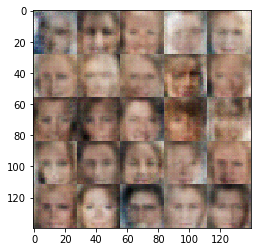

Step 1005/64 Epoch 1/1... Discriminator Loss: 0.1402... Generator Loss: 5.5227
Step 1010/64 Epoch 1/1... Discriminator Loss: 0.0798... Generator Loss: 9.2362
Step 1015/64 Epoch 1/1... Discriminator Loss: 0.3773... Generator Loss: 1.4183
Step 1020/64 Epoch 1/1... Discriminator Loss: 0.0382... Generator Loss: 6.6308
Step 1025/64 Epoch 1/1... Discriminator Loss: 0.4971... Generator Loss: 1.5001
Step 1030/64 Epoch 1/1... Discriminator Loss: 0.5332... Generator Loss: 6.1256
Step 1035/64 Epoch 1/1... Discriminator Loss: 0.2818... Generator Loss: 7.0835
Step 1040/64 Epoch 1/1... Discriminator Loss: 0.2133... Generator Loss: 2.8411
Step 1045/64 Epoch 1/1... Discriminator Loss: 0.5487... Generator Loss: 1.1308
Step 1050/64 Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 11.6772
Step 1055/64 Epoch 1/1... Discriminator Loss: 1.8083... Generator Loss: 0.2832
Step 1060/64 Epoch 1/1... Discriminator Loss: 0.0287... Generator Loss: 8.1680
Step 1065/64 Epoch 1/1... Discriminator Loss: 0.170

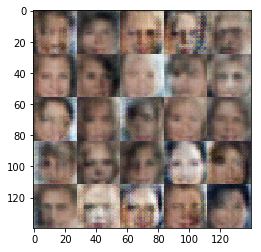

Step 1105/64 Epoch 1/1... Discriminator Loss: 0.4606... Generator Loss: 1.3529
Step 1110/64 Epoch 1/1... Discriminator Loss: 0.1662... Generator Loss: 5.7393
Step 1115/64 Epoch 1/1... Discriminator Loss: 0.0484... Generator Loss: 7.4156
Step 1120/64 Epoch 1/1... Discriminator Loss: 0.0285... Generator Loss: 6.2813
Step 1125/64 Epoch 1/1... Discriminator Loss: 0.0694... Generator Loss: 4.7477
Step 1130/64 Epoch 1/1... Discriminator Loss: 0.0262... Generator Loss: 5.5653
Step 1135/64 Epoch 1/1... Discriminator Loss: 0.1959... Generator Loss: 3.7215
Step 1140/64 Epoch 1/1... Discriminator Loss: 0.0901... Generator Loss: 3.9084
Step 1145/64 Epoch 1/1... Discriminator Loss: 0.1001... Generator Loss: 5.9689
Step 1150/64 Epoch 1/1... Discriminator Loss: 0.2023... Generator Loss: 2.2814
Step 1155/64 Epoch 1/1... Discriminator Loss: 0.0276... Generator Loss: 7.5877
Step 1160/64 Epoch 1/1... Discriminator Loss: 0.0549... Generator Loss: 12.1842
Step 1165/64 Epoch 1/1... Discriminator Loss: 1.575

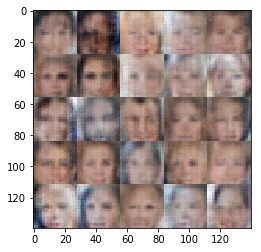

Step 1205/64 Epoch 1/1... Discriminator Loss: 0.0498... Generator Loss: 9.8967
Step 1210/64 Epoch 1/1... Discriminator Loss: 0.2823... Generator Loss: 2.5788
Step 1215/64 Epoch 1/1... Discriminator Loss: 0.4042... Generator Loss: 5.5659
Step 1220/64 Epoch 1/1... Discriminator Loss: 0.3278... Generator Loss: 9.5923
Step 1225/64 Epoch 1/1... Discriminator Loss: 0.0371... Generator Loss: 6.9729
Step 1230/64 Epoch 1/1... Discriminator Loss: 0.0469... Generator Loss: 6.7039
Step 1235/64 Epoch 1/1... Discriminator Loss: 0.0146... Generator Loss: 11.3578
Step 1240/64 Epoch 1/1... Discriminator Loss: 0.2790... Generator Loss: 7.0274
Step 1245/64 Epoch 1/1... Discriminator Loss: 0.0223... Generator Loss: 7.7469
Step 1250/64 Epoch 1/1... Discriminator Loss: 0.0259... Generator Loss: 8.1613
Step 1255/64 Epoch 1/1... Discriminator Loss: 0.1354... Generator Loss: 2.7347
Step 1260/64 Epoch 1/1... Discriminator Loss: 0.2329... Generator Loss: 11.4677
Step 1265/64 Epoch 1/1... Discriminator Loss: 0.28

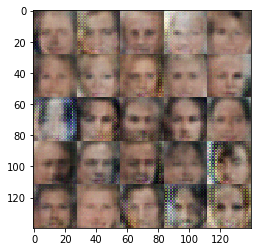

Step 1305/64 Epoch 1/1... Discriminator Loss: 0.4990... Generator Loss: 2.4868
Step 1310/64 Epoch 1/1... Discriminator Loss: 0.0145... Generator Loss: 7.4264
Step 1315/64 Epoch 1/1... Discriminator Loss: 0.0566... Generator Loss: 7.0951
Step 1320/64 Epoch 1/1... Discriminator Loss: 0.0448... Generator Loss: 10.9554
Step 1325/64 Epoch 1/1... Discriminator Loss: 0.6186... Generator Loss: 0.9321
Step 1330/64 Epoch 1/1... Discriminator Loss: 0.0259... Generator Loss: 5.2645
Step 1335/64 Epoch 1/1... Discriminator Loss: 0.2625... Generator Loss: 7.1311
Step 1340/64 Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 0.5166
Step 1345/64 Epoch 1/1... Discriminator Loss: 0.0352... Generator Loss: 12.3670
Step 1350/64 Epoch 1/1... Discriminator Loss: 0.0085... Generator Loss: 6.6097
Step 1355/64 Epoch 1/1... Discriminator Loss: 0.2249... Generator Loss: 1.9255
Step 1360/64 Epoch 1/1... Discriminator Loss: 0.0486... Generator Loss: 10.7507
Step 1365/64 Epoch 1/1... Discriminator Loss: 0.5

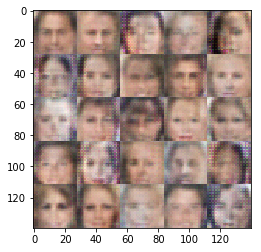

Step 1405/64 Epoch 1/1... Discriminator Loss: 0.1885... Generator Loss: 9.3195
Step 1410/64 Epoch 1/1... Discriminator Loss: 0.0270... Generator Loss: 7.7995
Step 1415/64 Epoch 1/1... Discriminator Loss: 0.0166... Generator Loss: 9.1115
Step 1420/64 Epoch 1/1... Discriminator Loss: 0.2322... Generator Loss: 8.3867
Step 1425/64 Epoch 1/1... Discriminator Loss: 0.0229... Generator Loss: 5.7423
Step 1430/64 Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 0.5465
Step 1435/64 Epoch 1/1... Discriminator Loss: 0.9372... Generator Loss: 2.6173
Step 1440/64 Epoch 1/1... Discriminator Loss: 0.5400... Generator Loss: 1.0655
Step 1445/64 Epoch 1/1... Discriminator Loss: 0.5198... Generator Loss: 1.2235
Step 1450/64 Epoch 1/1... Discriminator Loss: 0.0497... Generator Loss: 7.9378
Step 1455/64 Epoch 1/1... Discriminator Loss: 0.3887... Generator Loss: 6.7689
Step 1460/64 Epoch 1/1... Discriminator Loss: 0.0722... Generator Loss: 11.5364
Step 1465/64 Epoch 1/1... Discriminator Loss: 0.131

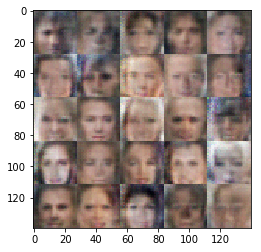

Step 1505/64 Epoch 1/1... Discriminator Loss: 0.0359... Generator Loss: 4.0167
Step 1510/64 Epoch 1/1... Discriminator Loss: 0.0408... Generator Loss: 6.2029
Step 1515/64 Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 0.5289
Step 1520/64 Epoch 1/1... Discriminator Loss: 0.0474... Generator Loss: 8.8556
Step 1525/64 Epoch 1/1... Discriminator Loss: 0.1199... Generator Loss: 10.6926
Step 1530/64 Epoch 1/1... Discriminator Loss: 0.1020... Generator Loss: 10.6020
Step 1535/64 Epoch 1/1... Discriminator Loss: 0.0474... Generator Loss: 5.0193
Step 1540/64 Epoch 1/1... Discriminator Loss: 0.0715... Generator Loss: 11.5753
Step 1545/64 Epoch 1/1... Discriminator Loss: 0.0201... Generator Loss: 7.8666
Step 1550/64 Epoch 1/1... Discriminator Loss: 0.1973... Generator Loss: 2.0919
Step 1555/64 Epoch 1/1... Discriminator Loss: 0.0256... Generator Loss: 11.5979
Step 1560/64 Epoch 1/1... Discriminator Loss: 0.0574... Generator Loss: 3.5066
Step 1565/64 Epoch 1/1... Discriminator Loss: 0.

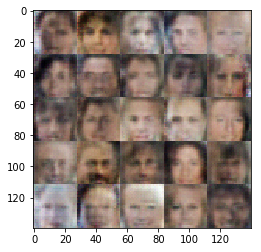

Step 1605/64 Epoch 1/1... Discriminator Loss: 0.1509... Generator Loss: 3.1667
Step 1610/64 Epoch 1/1... Discriminator Loss: 0.2837... Generator Loss: 1.9643
Step 1615/64 Epoch 1/1... Discriminator Loss: 0.0905... Generator Loss: 2.9891
Step 1620/64 Epoch 1/1... Discriminator Loss: 0.0783... Generator Loss: 4.0131
Step 1625/64 Epoch 1/1... Discriminator Loss: 0.0849... Generator Loss: 6.6547
Step 1630/64 Epoch 1/1... Discriminator Loss: 0.5319... Generator Loss: 11.2514
Step 1635/64 Epoch 1/1... Discriminator Loss: 0.0627... Generator Loss: 3.5131
Step 1640/64 Epoch 1/1... Discriminator Loss: 0.0500... Generator Loss: 3.7109
Step 1645/64 Epoch 1/1... Discriminator Loss: 0.0618... Generator Loss: 3.9496
Step 1650/64 Epoch 1/1... Discriminator Loss: 0.0331... Generator Loss: 5.0695
Step 1655/64 Epoch 1/1... Discriminator Loss: 0.0927... Generator Loss: 2.8662
Step 1660/64 Epoch 1/1... Discriminator Loss: 0.3543... Generator Loss: 1.8620
Step 1665/64 Epoch 1/1... Discriminator Loss: 0.109

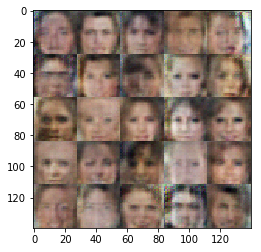

Step 1705/64 Epoch 1/1... Discriminator Loss: 0.5520... Generator Loss: 1.1273
Step 1710/64 Epoch 1/1... Discriminator Loss: 0.0285... Generator Loss: 10.8280
Step 1715/64 Epoch 1/1... Discriminator Loss: 0.0269... Generator Loss: 4.7223
Step 1720/64 Epoch 1/1... Discriminator Loss: 0.1806... Generator Loss: 2.3449
Step 1725/64 Epoch 1/1... Discriminator Loss: 0.0255... Generator Loss: 10.0831
Step 1730/64 Epoch 1/1... Discriminator Loss: 0.1598... Generator Loss: 2.2441
Step 1735/64 Epoch 1/1... Discriminator Loss: 0.0674... Generator Loss: 4.0240
Step 1740/64 Epoch 1/1... Discriminator Loss: 0.0091... Generator Loss: 10.8146
Step 1745/64 Epoch 1/1... Discriminator Loss: 0.0058... Generator Loss: 7.7412
Step 1750/64 Epoch 1/1... Discriminator Loss: 0.0278... Generator Loss: 5.8083
Step 1755/64 Epoch 1/1... Discriminator Loss: 0.0308... Generator Loss: 10.0798
Step 1760/64 Epoch 1/1... Discriminator Loss: 0.0650... Generator Loss: 3.3925
Step 1765/64 Epoch 1/1... Discriminator Loss: 1.

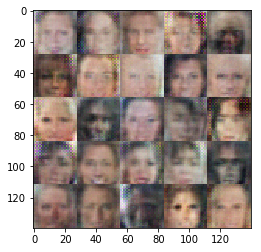

Step 1805/64 Epoch 1/1... Discriminator Loss: 0.0303... Generator Loss: 6.6000
Step 1810/64 Epoch 1/1... Discriminator Loss: 0.0384... Generator Loss: 10.6844
Step 1815/64 Epoch 1/1... Discriminator Loss: 0.0250... Generator Loss: 9.3033
Step 1820/64 Epoch 1/1... Discriminator Loss: 0.0215... Generator Loss: 9.2456
Step 1825/64 Epoch 1/1... Discriminator Loss: 0.0363... Generator Loss: 11.4960
Step 1830/64 Epoch 1/1... Discriminator Loss: 0.0129... Generator Loss: 8.8043
Step 1835/64 Epoch 1/1... Discriminator Loss: 0.2735... Generator Loss: 1.6616
Step 1840/64 Epoch 1/1... Discriminator Loss: 0.0416... Generator Loss: 7.0474
Step 1845/64 Epoch 1/1... Discriminator Loss: 0.0194... Generator Loss: 9.0639
Step 1850/64 Epoch 1/1... Discriminator Loss: 0.3652... Generator Loss: 10.9989
Step 1855/64 Epoch 1/1... Discriminator Loss: 0.0336... Generator Loss: 8.1744
Step 1860/64 Epoch 1/1... Discriminator Loss: 0.2508... Generator Loss: 4.7490
Step 1865/64 Epoch 1/1... Discriminator Loss: 0.0

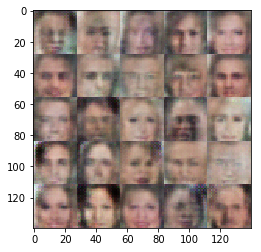

Step 1905/64 Epoch 1/1... Discriminator Loss: 0.2021... Generator Loss: 2.5023
Step 1910/64 Epoch 1/1... Discriminator Loss: 0.0407... Generator Loss: 12.5784


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.